In [156]:
import pandas as pd
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from IPython import display 
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import ascii
import fitsio
from scipy import spatial
from tqdm import tqdm

In [4]:
np.seterr(divide = 'ignore', invalid = "ignore") 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Import Clusters

In [5]:
clumper = Table.read("DESI_clusters_final_2023_speczs.fits").to_pandas()

In [4]:
len(clumper)

309115

In [5]:
clumper.columns

Index(['RA_central', 'DEC_central', 'z_median_central', 'z_average_no_wt',
       'z_average_prob', 'z_average_mass_prob', 'z_std_central',
       'z_stde_no_wt', 'z_stde_prob', 'z_stde_mass_prob', 'RELEASE', 'BRICKID',
       'OBJID', 'MASKBITS', 'gid', 'mass_central', 'cluster_mass_onempc',
       'cluster_mass_halfmpc', 'cluster_mass_tenthmpc', 'richness_onempc',
       'richness_halfmpc', 'richness_tenthmpc', 'spec_z', 'spec_z_err'],
      dtype='object')

In [6]:
table_of_centers = pd.read_csv("dr9_sweeps.csv")

In [7]:
157.3021, 26.3921

(157.3021, 26.3921)

In [8]:
clumper[np.logical_and.reduce((clumper.RA_central > 157.30, clumper.RA_central < 157.31, clumper.DEC_central > 26.3, clumper.DEC_central < 26.5))]

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_stde_no_wt,z_stde_prob,z_stde_mass_prob,...,gid,mass_central,cluster_mass_onempc,cluster_mass_halfmpc,cluster_mass_tenthmpc,richness_onempc,richness_halfmpc,richness_tenthmpc,spec_z,spec_z_err
143061,157.302004,26.392243,0.576963,0.529927,0.574317,0.575731,0.011198,0.015018,0.010717,0.010622,...,1.573020e+18,11.909006,12.7746,12.675105,12.561569,27.248162,34.692843,36.5,0.585502,0.00021


In [9]:
clumper[np.logical_and.reduce((clumper.RA_central > 335.53, clumper.RA_central < 335.54, clumper.DEC_central > 27.75, clumper.DEC_central < 27.77))]

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_stde_no_wt,z_stde_prob,z_stde_mass_prob,...,gid,mass_central,cluster_mass_onempc,cluster_mass_halfmpc,cluster_mass_tenthmpc,richness_onempc,richness_halfmpc,richness_tenthmpc,spec_z,spec_z_err
217157,335.535734,27.759863,0.488823,0.474212,0.478294,0.478505,0.014693,0.011553,0.008771,0.008717,...,3.355357e+18,11.965524,12.861669,12.740463,12.596159,34.991138,46.14116,49.2,-1.0,-1.0


In [10]:
len(table_of_centers)

723

# Import Quasars

### Info about DESI targets data structure

In [7]:
qso1_f = fits.open("https://data.desi.lbl.gov/public/ets/target/catalogs/dr9/1.1.1/targets/main/resolve/dark/targets-dark-hp-0.fits")

In [8]:
qso1 = qso1_f[1].data

In [9]:
qso1.columns

ColDefs(
    name = 'RELEASE'; format = 'I'
    name = 'BRICKID'; format = 'J'
    name = 'BRICKNAME'; format = '8A'
    name = 'BRICK_OBJID'; format = 'J'
    name = 'MORPHTYPE'; format = '4A'
    name = 'RA'; format = 'D'; unit = 'deg'
    name = 'RA_IVAR'; format = 'E'; unit = '1/deg^2'
    name = 'DEC'; format = 'D'; unit = 'deg'
    name = 'DEC_IVAR'; format = 'E'; unit = '1/deg^2'
    name = 'DCHISQ'; format = '5E'
    name = 'EBV'; format = 'E'; unit = 'mag'
    name = 'FLUX_G'; format = 'E'; unit = 'nanomaggy'
    name = 'FLUX_R'; format = 'E'; unit = 'nanomaggy'
    name = 'FLUX_Z'; format = 'E'; unit = 'nanomaggy'
    name = 'FLUX_IVAR_G'; format = 'E'; unit = '1/nanomaggy^2'
    name = 'FLUX_IVAR_R'; format = 'E'; unit = '1/nanomaggy^2'
    name = 'FLUX_IVAR_Z'; format = 'E'; unit = '1/nanomaggy^2'
    name = 'MW_TRANSMISSION_G'; format = 'E'
    name = 'MW_TRANSMISSION_R'; format = 'E'
    name = 'MW_TRANSMISSION_Z'; format = 'E'
    name = 'FRACFLUX_G'; format = 'E'
    na

In [10]:
from desitarget.targetmask import desi_mask as Mx

In [11]:
is_QSO = (qso1["DESI_TARGET"] & Mx["QSO"]) != 0

In [12]:
is_QSO

array([False,  True, False, ...,  True, False, False])

In [13]:
qso = qso1[is_QSO]

In [14]:
qsos = pd.DataFrame(np.array([qso.RA, qso.DEC, qso.MASKBITS]).T, columns = ["RA", "DEC", "MASKBITS"])

### Actual full import (only need to run once)

In [16]:
qso_list = pd.DataFrame(np.empty((0, 7)), columns = ["RA", "DEC", "g_r_color", "g_z_color", "r_W1_color", "mag_g", "MASKBITS"])

In [17]:
import requests
import re
from desitarget.targetmask import desi_mask as Mx
r = requests.get('https://data.desi.lbl.gov/public/ets/target/catalogs/dr9/1.1.1/targets/main/resolve/dark/')
files = re.findall(r'targets.*\.fits\"', r.text)

In [21]:
pbar = display.ProgressBar(len(files))
pbar.display()
for index, row in enumerate(files):
    url_string = 'https://data.desi.lbl.gov/public/ets/target/catalogs/dr9/1.1.1/targets/main/resolve/dark/' + row[:-1]
    row_imported = fits.open(url_string, cache = False)[1].data
    is_QSO = (row_imported["DESI_TARGET"] & Mx["QSO"]) != 0
    row_data = row_imported[is_QSO]
    color_g_r = ( 22.5-2.5*np.log10(row_data.FLUX_G) ) - ( 22.5-2.5*np.log10(row_data.FLUX_R) )
    color_g_z = ( 22.5-2.5*np.log10(row_data.FLUX_G) ) - ( 22.5-2.5*np.log10(row_data.FLUX_Z) )
    color_r_W1 = ( 22.5-2.5*np.log10(row_data.FLUX_R) ) - ( 22.5-2.5*np.log10(row_data.FLUX_W1) )
    mag_g = 22.5-2.5*np.log10(row_data.FLUX_G)
    row_data_arr = np.array([row_data.RA, row_data.DEC, color_g_r, color_g_z, color_r_W1, row_data.MASKBITS]).T
    qso_list = qso_list.append(pd.DataFrame(row_data_arr, columns = ["RA", "DEC", "g_r_color", "g_z_color", "r_W1_color", "mag_g", "MASKBITS"]),ignore_index=True)
    pbar.progress = index

[=========================================================== ] 459/460

In [22]:
len(qso_list)

6307291

In [23]:
qso_list

,RA,DEC,g_r_color,g_z_color,r_W1_color,MASKBITS
0,39.878728,4.809761,0.620165,0.856932,2.461382,0.0
1,39.890382,4.688711,0.484722,0.660442,0.456156,0.0
2,39.891161,4.678912,0.478987,0.633865,0.644394,0.0
3,39.905769,4.853740,0.551043,0.774075,1.938326,0.0
4,39.929984,4.746993,0.406101,1.029596,1.426561,0.0
5,39.932220,4.754086,1.192001,1.391314,0.531406,0.0
6,39.948557,4.798035,0.487864,1.222221,2.098623,0.0
7,39.976393,4.731851,1.158333,2.089863,3.071613,0.0
8,39.977969,4.737008,0.461861,0.612383,0.624956,2048.0
9,39.981619,4.868006,0.469255,1.020042,1.026361,0.0


In [24]:
qso_table = Table.from_pandas(qso_list)
qso_table.write(f'qso.fits', format = 'fits')

### Full import for bright targets

In [11]:
qso_list = pd.DataFrame(np.empty((0, 7)), columns = ["RA", "DEC", "g_r_color", "g_z_color", "r_W1_color", "mag_g", "MASKBITS"])

In [12]:
import requests
import re
from desitarget.targetmask import desi_mask as Mx
r = requests.get('https://data.desi.lbl.gov/public/ets/target/catalogs/dr9/1.1.1/targets/main/resolve/bright/')
files = re.findall(r'targets.*\.fits\"', r.text)

KeyboardInterrupt: 

In [ ]:
pbar = display.ProgressBar(len(files))
pbar.display()
for index, row in enumerate(files):
    url_string = 'https://data.desi.lbl.gov/public/ets/target/catalogs/dr9/1.1.1/targets/main/resolve/bright/' + row[:-1]
    row_imported = fits.open(url_string, cache = False)[1].data
    is_QSO = (row_imported["DESI_TARGET"] & Mx["QSO"]) != 0
    row_data = row_imported[is_QSO]
    color_g_r = ( 22.5-2.5*np.log10(row_data.FLUX_G) ) - ( 22.5-2.5*np.log10(row_data.FLUX_R) )
    color_g_z = ( 22.5-2.5*np.log10(row_data.FLUX_G) ) - ( 22.5-2.5*np.log10(row_data.FLUX_Z) )
    color_r_W1 = ( 22.5-2.5*np.log10(row_data.FLUX_R) ) - ( 22.5-2.5*np.log10(row_data.FLUX_W1) )
    mag_g = 22.5-2.5*np.log10(row_data.FLUX_G)
    row_data_arr = np.array([row_data.RA, row_data.DEC, color_g_r, color_g_z, color_r_W1, mag_g, row_data.MASKBITS]).T
    qso_list = qso_list.append(pd.DataFrame(row_data_arr, columns = ["RA", "DEC", "g_r_color", "g_z_color", "r_W1_color", "mag_g", "MASKBITS"]),ignore_index=True)
    pbar.progress = index

In [23]:
len(qso_list)

158051

In [24]:
qso_list

,RA,DEC,g_r_color,g_z_color,r_W1_color,mag_g,MASKBITS
0,39.666334,4.919948,0.245193,0.518328,0.592117,18.871059,0.0
1,39.885333,4.968324,0.467726,0.887175,1.829170,19.628473,0.0
2,39.690699,4.550686,0.359528,0.449751,0.071035,18.648458,0.0
3,39.728689,4.610544,0.215834,0.414221,0.740681,18.360109,0.0
4,39.618280,4.753092,0.214865,0.584492,0.540453,19.077579,0.0
...,...,...,...,...,...,...,...
158046,113.253769,31.973306,0.508831,0.889864,0.701710,19.303020,0.0
158047,113.315857,32.276512,0.349756,0.018175,1.008232,20.546850,256.0
158048,113.355848,32.130338,0.176769,0.553968,0.401516,18.338753,0.0
158049,113.976589,31.727471,1.402931,1.606226,0.439791,20.311460,0.0


In [25]:
qso_table = Table.from_pandas(qso_list)
qso_table.write(f'qso_bright.fits', format = 'fits')

### Full import for secondary targets

In [16]:
qso_red = Table.read("https://data.desi.lbl.gov/public/ets/target/secondary/main/indata/QSO_RED.fits").to_pandas()

In [17]:
qso_red.head()

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE
0,29.365945,5.553019,0.0,0.0,0.0,False
1,29.070647,-5.089211,0.0,0.0,0.0,False
2,32.301400,7.380854,0.0,0.0,0.0,False
3,32.413747,8.050490,0.0,0.0,0.0,False
4,32.727685,6.643685,0.0,0.0,0.0,False


In [18]:
wise_qso = Table.read("Data/WISE_VAR_QSO.fits").to_pandas()

In [19]:
wise_qso.head()

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,Chi2,A,gamma,Nb,proba_rf,r
0,68.444839,68.857079,0.000000,0.000000,0.0,False,1.570413,0.047335,1.239165,14,0.611996,21.291628
1,68.445601,68.657685,5.469973,4.204937,2015.5,False,5.336825,0.461118,0.259201,14,0.463497,19.385780
2,68.447177,68.742283,1.884198,0.078050,2015.5,False,1.209924,0.002649,2.191756,14,0.457928,18.924431
3,68.454309,68.859147,0.000000,0.000000,0.0,False,1.056097,0.009251,1.898731,14,0.619872,21.255350
4,68.455548,68.757540,-3.128536,-0.375558,2015.5,False,1.434551,0.138543,0.017566,14,0.469095,18.984087


In [20]:
z5_qso = Table.read("https://data.desi.lbl.gov/public/ets/target/secondary/main/indata/Z5_QSO.fits").to_pandas()

In [21]:
z5_qso.head()

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE
0,0.048421,-13.803002,0.0,0.0,2015.5,False
1,0.448501,-3.879856,0.0,0.0,0.0,False
2,0.483687,7.478866,0.0,0.0,0.0,False
3,0.507473,-8.963200,0.0,0.0,0.0,False
4,0.587830,-9.730343,0.0,0.0,0.0,False


In [22]:
qso_red[np.logical_and.reduce((qso_red.RA < 336, qso_red.RA > 335, qso_red.DEC < 28, qso_red.DEC > 27))]

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE
14186,335.818782,27.173431,0.000000,0.000000,0.0,False
14190,335.533256,27.254981,-1.096171,0.275142,2015.5,False
14191,335.695912,27.017350,0.000000,0.000000,0.0,False


In [23]:
qso_red[np.logical_and.reduce((qso_red.RA < 158, qso_red.RA > 157, qso_red.DEC < 27, qso_red.DEC > 26))]

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE
2613,157.818545,26.442984,0.0,0.0,0.0,False


In [24]:
wise_qso[np.logical_and.reduce((wise_qso.RA < 336.54, wise_qso.RA > 335.52, wise_qso.DEC < 27.76, wise_qso.DEC > 27.75))]

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,Chi2,A,gamma,Nb,proba_rf,r
3162584,336.402505,27.758142,0.772185,-0.747265,2015.5,False,15.470597,0.080997,0.736566,14,0.998802,19.685600
3162589,336.528211,27.752521,0.000000,0.000000,0.0,False,1.585694,0.014338,1.510489,14,0.989760,21.340881


In [25]:
wise_qso[np.logical_and.reduce((wise_qso.RA < 157.32, wise_qso.RA > 157.30, wise_qso.DEC < 27, wise_qso.DEC > 26))]

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,Chi2,A,gamma,Nb,proba_rf,r
2004366,157.307159,26.544795,0.000000,0.000000,0.0,False,2.544286,0.220887,0.174291,14,0.996783,20.845798
2004367,157.308112,26.388320,0.060605,-0.145503,2015.5,False,13.645814,0.104195,0.111091,14,0.998803,18.578562
2004368,157.314953,26.495821,0.000000,0.000000,0.0,False,2.332375,0.288868,0.091924,14,0.998198,20.890503


In [26]:
z5_qso[np.logical_and.reduce((z5_qso.RA < 336.54, z5_qso.RA > 335.53, z5_qso.DEC < 27.76, z5_qso.DEC > 27.75))]

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE


In [27]:
z5_qso[np.logical_and.reduce((z5_qso.RA < 157.32, z5_qso.RA > 157.30, z5_qso.DEC < 27, z5_qso.DEC > 26))]

,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE


In [25]:
335.5364, 27.7591
157.3082, 26.3924

(157.3082, 26.3924)

### Normal import

In [6]:
qso_d = Table.read("qso.fits").to_pandas()

In [7]:
qso_b = Table.read("qso_bright.fits").to_pandas()

In [8]:
qso_b

,RA,DEC,g_r_color,g_z_color,r_W1_color,mag_g,MASKBITS
0,39.666334,4.919948,0.245193,0.518328,0.592117,18.871059,0.0
1,39.885333,4.968324,0.467726,0.887175,1.829170,19.628473,0.0
2,39.690699,4.550686,0.359528,0.449751,0.071035,18.648458,0.0
3,39.728689,4.610544,0.215834,0.414221,0.740681,18.360109,0.0
4,39.618280,4.753092,0.214865,0.584492,0.540453,19.077579,0.0
...,...,...,...,...,...,...,...
158046,113.253769,31.973306,0.508831,0.889864,0.701710,19.303020,0.0
158047,113.315857,32.276512,0.349756,0.018175,1.008232,20.546850,256.0
158048,113.355848,32.130338,0.176769,0.553968,0.401516,18.338753,0.0
158049,113.976589,31.727471,1.402931,1.606226,0.439791,20.311460,0.0


In [9]:
qso_d

,RA,DEC,g_r_color,g_z_color,r_W1_color,MASKBITS
0,39.878728,4.809761,0.620165,0.856932,2.461382,0.0
1,39.890382,4.688711,0.484722,0.660442,0.456156,0.0
2,39.891161,4.678912,0.478987,0.633865,0.644394,0.0
3,39.905769,4.853740,0.551043,0.774075,1.938326,0.0
4,39.929984,4.746993,0.406101,1.029596,1.426561,0.0
...,...,...,...,...,...,...
6307286,113.469826,31.577750,0.301523,0.717890,2.672220,0.0
6307287,113.484613,31.415002,0.584347,1.560684,1.934528,0.0
6307288,113.512488,31.624379,0.089468,0.191359,1.450380,0.0
6307289,113.539283,31.617752,0.029392,0.497074,1.563940,2048.0


In [10]:
qso_d["mag_g"] = np.zeros(len(qso_d))

In [11]:
qsos = pd.concat([qso_d, qso_b], axis = 0)

In [12]:
qsos

,RA,DEC,g_r_color,g_z_color,r_W1_color,MASKBITS,mag_g
0,39.878728,4.809761,0.620165,0.856932,2.461382,0.0,0.000000
1,39.890382,4.688711,0.484722,0.660442,0.456156,0.0,0.000000
2,39.891161,4.678912,0.478987,0.633865,0.644394,0.0,0.000000
3,39.905769,4.853740,0.551043,0.774075,1.938326,0.0,0.000000
4,39.929984,4.746993,0.406101,1.029596,1.426561,0.0,0.000000
...,...,...,...,...,...,...,...
158046,113.253769,31.973306,0.508831,0.889864,0.701710,0.0,19.303020
158047,113.315857,32.276512,0.349756,0.018175,1.008232,256.0,20.546850
158048,113.355848,32.130338,0.176769,0.553968,0.401516,0.0,18.338753
158049,113.976589,31.727471,1.402931,1.606226,0.439791,0.0,20.311460


In [13]:
qsos = qsos[qsos.MASKBITS == 0]

In [14]:
qsos = qsos.drop_duplicates(subset = ["RA", "DEC"]).drop(columns = "MASKBITS")

In [15]:
len(qsos)

5830514

In [118]:
qsos.head()

,RA,DEC,g_r_color,g_z_color,r_W1_color,mag_g
0,39.878728,4.809761,0.620165,0.856932,2.461382,0.0
1,39.890382,4.688711,0.484722,0.660442,0.456156,0.0
2,39.891161,4.678912,0.478987,0.633865,0.644394,0.0
3,39.905769,4.853740,0.551043,0.774075,1.938326,0.0
4,39.929984,4.746993,0.406101,1.029596,1.426561,0.0


In [119]:
qsos[np.logical_and.reduce((qsos.RA < 201.51, qsos.RA > 201.49, qsos.DEC < 48.12, qsos.DEC > 48.10))]

,RA,DEC,g_r_color,g_z_color,r_W1_color,mag_g
1224362,201.496635,48.115585,0.033205,0.591871,2.745253,0.0


In [120]:
qsos[np.logical_and.reduce((qsos.RA < 336.54, qsos.RA > 335.53, qsos.DEC < 27.77, qsos.DEC > 27.75))]

,RA,DEC,g_r_color,g_z_color,r_W1_color,mag_g
1709875,335.537678,27.760523,0.224333,0.035391,0.588442,0.0
1709950,335.737968,27.768327,0.343082,0.387482,0.965021,0.0
1709955,335.854516,27.758791,0.218988,0.839212,2.502256,0.0
1710792,336.104012,27.760241,0.268349,0.163595,0.877073,0.0
1710802,336.201674,27.760773,0.730890,1.144854,2.593052,0.0
1711355,336.346383,27.761276,0.209684,0.503002,1.264614,0.0
1711359,336.402505,27.758142,0.218178,0.341820,1.445570,0.0
1711363,336.528211,27.752521,0.683792,1.417103,1.546539,0.0


In [121]:
qsos[np.logical_and.reduce((qsos.RA < 157.32, qsos.RA > 157.30, qsos.DEC < 26.7, qsos.DEC > 26.2))]

,RA,DEC,g_r_color,g_z_color,r_W1_color,mag_g
5978322,157.301327,26.560508,0.296089,0.012123,1.679972,0.0
5978323,157.307159,26.544795,0.388205,0.337841,1.267927,0.0
5978324,157.307811,26.572341,0.074091,-0.014479,1.518703,0.0
5978325,157.308112,26.388320,0.107792,0.485989,0.837582,0.0
5978326,157.308606,26.540315,-0.164949,-0.048412,1.056295,0.0
5978327,157.309369,26.394478,0.145916,0.565481,0.545076,0.0
5978328,157.309585,26.394008,0.326239,1.057489,2.444483,0.0
5978329,157.314953,26.495821,-0.010933,0.295084,0.678143,0.0


In [125]:
qsos[np.logical_and.reduce((qsos.RA < 244, qsos.RA > 243.9, qsos.DEC < 6.83, qsos.DEC > 6.76))][["RA", "DEC"]]

,RA,DEC
4010192,243.936426,6.790090
4010193,243.938844,6.788182
4010194,243.945734,6.803542
4010195,243.947595,6.787755
4010197,243.957091,6.789072
4010198,243.975624,6.812606


In [ ]:
243.948290020042 6.790366217129265

In [134]:
clumper[np.logical_and.reduce((clumper.RA_central < 244, clumper.RA_central > 243.9, clumper.DEC_central < 6.83, clumper.DEC_central > 6.76))]

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_stde_no_wt,z_stde_prob,z_stde_mass_prob,...,gid,mass_central,cluster_mass_onempc,cluster_mass_halfmpc,cluster_mass_tenthmpc,richness_onempc,richness_halfmpc,richness_tenthmpc,spec_z,spec_z_err
274252,243.948290,6.790366,0.332528,0.384990,0.357257,0.357523,0.011305,0.011052,0.008358,0.008339,...,2439482900096790528.000000,11.447253,12.552621,12.220285,11.938919,41.154581,57.416851,62.533333,-1.000000,-1.000000


In [133]:
pd.set_option('float_format', '{:f}'.format)
clumper[np.logical_and.reduce((clumper.RA_central < 157.32, clumper.RA_central > 157.30, clumper.DEC_central < 26.7, clumper.DEC_central > 26.2))]

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_stde_no_wt,z_stde_prob,z_stde_mass_prob,...,gid,mass_central,cluster_mass_onempc,cluster_mass_halfmpc,cluster_mass_tenthmpc,richness_onempc,richness_halfmpc,richness_tenthmpc,spec_z,spec_z_err
143061,157.302004,26.392243,0.576963,0.529927,0.574317,0.575731,0.011198,0.015018,0.010717,0.010622,...,1573020040116392192.000000,11.909006,12.774600,12.675105,12.561569,27.248162,34.692843,36.500000,0.585502,0.000210


In [273]:
clumper[np.logical_and.reduce((clumper.RA_central < 137.50, clumper.RA_central > 137.40, clumper.DEC_central < 45, clumper.DEC_central > 44))]

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_stde_no_wt,z_stde_prob,z_stde_mass_prob,...,cluster_mass_tenthmpc,richness_onempc,richness_halfmpc,richness_tenthmpc,spec_z,spec_z_err,RA_r,DEC_r,x,y


In [274]:
data = ascii.read("Data/clusters.dat").to_pandas()
columns = ["ID",
    "RA",
    "DEC",
    "zphot",
    "zspec",
    "den",
    "Bkg",
    "RAMdeg",
    "DEMdeg",
    "Ng",
    "Ltot",
    "M500",
    "R500",
    "Richness",
    "RABdeg",
    "DEBdeg",
    "zphotB",
    "e_zphotB",
    "zspecB",
    "gmag",
    "rmag",
    "zmag",
    "W1mag",
    "W2mag",
    "e_gmag",
    "e_rmag",
    "e_zmag",
    "e_W1mag",
    "e_W2mag",
    "gMag",
    "rMag",
    "zMag",
    "W1Mag",
    "W2Mag",
    "Mass",
    "b_Mass",
    "B_Mass"]
data.columns = columns

In [275]:
data[np.logical_and.reduce((data.RA < 137.50, data.RA > 137.40, data.DEC < 45, data.DEC > 44))]

,ID,RA,DEC,zphot,zspec,den,Bkg,RAMdeg,DEMdeg,Ng,...,e_W1mag,e_W2mag,gMag,rMag,zMag,W1Mag,W2Mag,Mass,b_Mass,B_Mass
83366,717100052,137.475675,44.573981,0.65109,-10.0,14,2.915184,137.470447,44.581292,17.3315,...,0.01888,0.06242,-22.208,-22.863,-23.247,-22.808,-22.412,10.9603,10.9243,11.1042


In [ ]:
clumper[np.logical_and.reduce((coords[0] < 137.40, coords[0] > 147.50, coords[1] < 45, coords[1] > 44))]

In [28]:
qsos["RA_r"] = (np.pi/180)*qsos["RA"]
qsos["DEC_r"] = (np.pi/180)*qsos["DEC"]

z5_qso["RA_r"] = (np.pi/180)*z5_qso["RA"]
z5_qso["DEC_r"] = (np.pi/180)*z5_qso["DEC"]

qso_red["RA_r"] = (np.pi/180)*qso_red["RA"]
qso_red["DEC_r"] = (np.pi/180)*qso_red["DEC"]

clumper["RA_r"] = (np.pi/180)*clumper["RA_central"]
clumper["DEC_r"] = (np.pi/180)*clumper["DEC_central"]

In [29]:
qsos["x"] = (qsos["RA_r"])*np.cos(qsos["DEC_r"]) + 50
qsos["y"] = qsos["DEC_r"] + 50

z5_qso["x"] = (z5_qso["RA_r"])*np.cos(z5_qso["DEC_r"]) + 50
z5_qso["y"] = z5_qso["DEC_r"] + 50

qso_red["x"] = (qso_red["RA_r"])*np.cos(qso_red["DEC_r"]) + 50
qso_red["y"] = qso_red["DEC_r"] + 50

clumper["x"] = (clumper["RA_r"])*np.cos(clumper["DEC_r"]) + 50
clumper["y"] = clumper["DEC_r"] + 50

In [30]:
tree = spatial.cKDTree(qsos[["x", "y"]].values.astype(float), copy_data = True)
tree2 = spatial.cKDTree(qso_red[["x", "y"]].values.astype(float), copy_data = True)
tree3 = spatial.cKDTree(z5_qso[["x", "y"]].values.astype(float), copy_data = True)

In [31]:
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import LambdaCDM as Cos

In [32]:
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)

In [33]:
def e_radius(z, M = 10**15*const.M_sun):
    d_ang = (cos.comoving_distance(z).to(u.m))/(1+z)
    return np.sqrt(4*const.G*M / (d_ang * const.c**2) )

In [34]:
e_radius(0.5, M = 0.25*10**15*const.M_sun).value * (180/np.pi)* (60)*(60)

40.11401363816035

In [35]:
clumper.columns

Index(['RA_central', 'DEC_central', 'z_median_central', 'z_average_no_wt',
       'z_average_prob', 'z_average_mass_prob', 'z_std_central',
       'z_stde_no_wt', 'z_stde_prob', 'z_stde_mass_prob', 'RELEASE', 'BRICKID',
       'OBJID', 'MASKBITS', 'gid', 'mass_central', 'cluster_mass_onempc',
       'cluster_mass_halfmpc', 'cluster_mass_tenthmpc', 'richness_onempc',
       'richness_halfmpc', 'richness_tenthmpc', 'spec_z', 'spec_z_err', 'RA_r',
       'DEC_r', 'x', 'y'],
      dtype='object')

In [36]:
massive_clumper = clumper[clumper.cluster_mass_onempc > 0].sort_values(by = "cluster_mass_onempc", ascending = False).copy().reset_index()

In [37]:
z_lens = massive_clumper.at[0, "z_average_prob"]
e_radius(z_lens).value

0.00041244974109090875

In [38]:
qsos.head()

,RA,DEC,g_r_color,g_z_color,r_W1_color,mag_g,RA_r,DEC_r,x,y
0,39.878728,4.809761,0.620165,0.856932,2.461382,0.0,0.696015,0.083946,50.693564,50.083946
1,39.890382,4.688711,0.484722,0.660442,0.456156,0.0,0.696219,0.081833,50.693889,50.081833
2,39.891161,4.678912,0.478987,0.633865,0.644394,0.0,0.696232,0.081662,50.693912,50.081662
3,39.905769,4.853740,0.551043,0.774075,1.938326,0.0,0.696487,0.084714,50.693989,50.084714
4,39.929984,4.746993,0.406101,1.029596,1.426561,0.0,0.696910,0.082851,50.694519,50.082851


In [185]:
qso_indexable = qsos.values.astype(float)
lensed_qso = []
for i in tqdm(range(len(massive_clumper)), position=0, leave=True):
    z_lens = massive_clumper.at[i, "z_average_prob"]
    e_rad = e_radius(z_lens)
    neighbors = tree.query_ball_point([massive_clumper.at[i, "x"], massive_clumper.at[i, "y"]], 0.5*e_rad.value)
    field = tree.query_ball_point([massive_clumper.at[i, "x"], massive_clumper.at[i, "y"]], 3*e_rad.value)
    if len(neighbors) > 1:
        if len(field) < 6*len(neighbors):
            l_qso = qso_indexable[neighbors]
            lensed_qso.append([[massive_clumper.iloc[i], l_qso]])

100%|██████████| 309115/309115 [01:09<00:00, 4427.24it/s]


In [141]:
qso_indexable = qso_red.values.astype(float)
lensed_qso_red = []
for i in tqdm(range(len(massive_clumper)), position=0, leave=True):
    z_lens = massive_clumper.at[i, "z_average_prob"]
    e_rad = e_radius(z_lens)
    neighbors = tree2.query_ball_point([massive_clumper.at[i, "x"], massive_clumper.at[i, "y"]], 1*e_rad.value)
    field = tree.query_ball_point([massive_clumper.at[i, "x"], massive_clumper.at[i, "y"]], 3*e_rad.value)
    if len(neighbors) > 1:
        if len(field) < 6*len(neighbors):
            l_qso = qso_indexable[neighbors]
            lensed_qso_red.append([[massive_clumper.iloc[i], l_qso]])

100%|██████████| 309115/309115 [01:10<00:00, 4373.75it/s]


In [81]:
qso_indexable = z5_qso.values.astype(float)
lensed_qso_z5 = []
for i in tqdm(range(len(massive_clumper)), position=0, leave=True):
    z_lens = massive_clumper.at[i, "z_average_prob"]
    e_rad = e_radius(z_lens)
    neighbors = tree3.query_ball_point([massive_clumper.at[i, "x"], massive_clumper.at[i, "y"]], 0.5*e_rad.value)
    field = tree.query_ball_point([massive_clumper.at[i, "x"], massive_clumper.at[i, "y"]], 3*e_rad.value)
    if len(neighbors) > 1:
        if len(field) < 6*len(neighbors):
            l_qso = qso_indexable[neighbors]
            lensed_qso_z5.append([[massive_clumper.iloc[i], l_qso]])

100%|██████████| 309115/309115 [01:25<00:00, 3616.03it/s]


In [120]:
print(len(lensed_qso))

25801


In [121]:
from sklearn.metrics import pairwise_distances

def custom_calc(x,y):
    return (y-x)

a = np.array([0, 0.5, 1.1, 1])
matrix = np.abs(pairwise_distances(a.reshape(-1,1), metric=custom_calc))
matrix += np.eye(len(matrix))

In [122]:
matrix

array([[1. , 0.5, 1.1, 1. ],
       [0.5, 1. , 0.6, 0.5],
       [1.1, 0.6, 1. , 0.1],
       [1. , 0.5, 0.1, 1. ]])

In [123]:
np.sum(matrix < 1)

8

In [124]:
lensed_qso[3][0][1][:, 2]

array([0.65269279, 0.2842083 ])

In [125]:
np.log10(0.5*10**15)

14.698970004336019

In [204]:
lensed_qso_close = []
max_dupl = 0
for i in range(len(lensed_qso)):
    if len(lensed_qso[i][0][1]) > 1:
        #Calculate minimum color differences for each color
        vals_gr = lensed_qso[i][0][1][:, 2]
        vals_gz = lensed_qso[i][0][1][:, 3]
        vals_rw1 = lensed_qso[i][0][1][:, 4]
        
        diff_gr = np.abs(pairwise_distances(vals_gr.reshape(-1,1), metric=custom_calc))
        diff_gz = np.abs(pairwise_distances(vals_gz.reshape(-1,1), metric=custom_calc))
        diff_rw1 = np.abs(pairwise_distances(vals_rw1.reshape(-1,1), metric=custom_calc))
        
        diff_gr += np.eye(len(diff_gr))
        diff_gz += np.eye(len(diff_gz))
        diff_rw1 += np.eye(len(diff_rw1))
        
        min_gr = np.sum(diff_gr < 1)
        min_gz = np.sum(diff_gz < 1)
        min_rw1 = np.sum(diff_rw1 < 1)
        
        if np.logical_and.reduce((min_gr > 6, min_gz > 6, min_rw1 > 6)): #Grade C: >1, Grade B: >5, Grade A: >6
            lensed_qso_close.append(lensed_qso[i][0])

In [205]:
len(lensed_qso_close)

5

In [206]:
lensed_qso_quad_highz = []
for i in range(len(lensed_qso_close)):
    if np.logical_and(lensed_qso_close[i][0].z_median_central > 0.1, lensed_qso_close[i][0].z_median_central <2):
        lensed_qso_quad_highz.append(lensed_qso_close[i])

In [207]:
len(lensed_qso_quad_highz)

5

In [208]:
df_lensed_qso = pd.DataFrame(data = None, columns = ["RA_central", "DEC_central", "spec_z", "spec_z_err", "z_median_central", "cluster_mass_onempc", "gid", "QSO_RA", "QSO_DEC", "g_r", "g_z", "r_w1"])
df_lensed_qso["lens_RA_central"] = np.zeros(len(lensed_qso_quad_highz))
df_lensed_qso["lens_DEC_central"] = np.zeros(len(lensed_qso_quad_highz))
df_lensed_qso["lens_spec_z"] = np.zeros(len(lensed_qso_quad_highz))
df_lensed_qso["lens_spec_z_err"] = np.zeros(len(lensed_qso_quad_highz))
df_lensed_qso["lens_z_median_central"] = np.zeros(len(lensed_qso_quad_highz))
df_lensed_qso["lens_cluster_mass_onempc"] = np.zeros(len(lensed_qso_quad_highz))
df_lensed_qso["lens_gid"] = np.zeros(len(lensed_qso_quad_highz))
df_lensed_qso["QSO_RA"] = np.empty(len(lensed_qso_quad_highz), dtype = "object")
df_lensed_qso["QSO_DEC"] = np.empty(len(lensed_qso_quad_highz), dtype = "object")
df_lensed_qso["g_r"] = np.empty(len(lensed_qso_quad_highz), dtype = "object")
df_lensed_qso["g_z"] = np.empty(len(lensed_qso_quad_highz), dtype = "object")
df_lensed_qso["r_w1"] = np.empty(len(lensed_qso_quad_highz), dtype = "object")

In [209]:
for i in range(len(lensed_qso_quad_highz)):
    df_lensed_qso.at[i, "lens_RA_central"] = lensed_qso_quad_highz[i][0][["RA_central"]].values
    df_lensed_qso.at[i, "lens_DEC_central"] = lensed_qso_quad_highz[i][0][["DEC_central"]].values
    df_lensed_qso.at[i, "lens_spec_z"] = lensed_qso_quad_highz[i][0][["spec_z"]].values
    df_lensed_qso.at[i, "lens_spec_z_err"] = lensed_qso_quad_highz[i][0][["spec_z_err"]].values
    df_lensed_qso.at[i, "lens_z_median_central"] = lensed_qso_quad_highz[i][0][["z_median_central"]].values
    df_lensed_qso.at[i, "lens_cluster_mass_onempc"] = lensed_qso_quad_highz[i][0][["cluster_mass_onempc"]].values
    df_lensed_qso.at[i, "lens_gid"] = lensed_qso_quad_highz[i][0][["gid"]].values
    df_lensed_qso.at[i, "QSO_RA"] = lensed_qso_quad_highz[i][1][:, 0]
    df_lensed_qso.at[i, "QSO_DEC"] = lensed_qso_quad_highz[i][1][:, 1]
    df_lensed_qso.at[i, "g_r"] = lensed_qso_quad_highz[i][1][:, 2]
    df_lensed_qso.at[i, "g_z"] = lensed_qso_quad_highz[i][1][:, 3]
    df_lensed_qso.at[i, "r_w1"] = lensed_qso_quad_highz[i][1][:, 4]

In [210]:
ra = fits.Column(name='lens_RA_central', format='D', array=df_lensed_qso["lens_RA_central"].values)
dec = fits.Column(name='lens_DEC_central', format='D', array=df_lensed_qso["lens_DEC_central"].values)

spec = fits.Column(name='lens_spec_z', format='D', array=df_lensed_qso["lens_spec_z"].values)
spece = fits.Column(name='lens_spec_z_err', format='D', array=df_lensed_qso["lens_spec_z_err"].values)
zmed = fits.Column(name='lens_z_median_central', format='D', array=df_lensed_qso["lens_z_median_central"].values)
mass = fits.Column(name='lens_cluster_mass_onempc', format='D', array=df_lensed_qso["lens_cluster_mass_onempc"].values)
gid = fits.Column(name='lens_gid', format='D', array=df_lensed_qso["lens_gid"].values)

qra = fits.Column(name='QSO_RA', format='PD()', array=df_lensed_qso["QSO_RA"].values)
qdec = fits.Column(name='QSO_DEC', format='PD()', array=df_lensed_qso["QSO_DEC"].values)
gr = fits.Column(name='g_r', format='PD()', array=df_lensed_qso["g_r"].values)
gz = fits.Column(name='g_z', format='PD()', array=df_lensed_qso["g_z"].values)
rw = fits.Column(name='r_w1', format='PD()', array=df_lensed_qso["r_w1"].values)

In [211]:
hdu = fits.BinTableHDU.from_columns([ra, dec, spec, spece, zmed, mass, gid, qra, qdec, gr, gz, rw])

In [212]:
hdu.writeto('grade_a_core_lensed.fits')

In [186]:
lensed_qso_red

[[[index                    1.206540e+05
   RA_central               1.551224e+02
   DEC_central             -5.840244e+00
   z_median_central         3.954207e-01
   z_average_no_wt          4.243174e-01
   z_average_prob           4.186733e-01
   z_average_mass_prob      4.187189e-01
   z_std_central            2.009702e-02
   z_stde_no_wt             6.027472e-03
   z_stde_prob              4.165116e-03
   z_stde_mass_prob         4.118320e-03
   RELEASE                  9.010000e+03
   BRICKID                  2.979030e+05
   OBJID                    4.749000e+03
   MASKBITS                 0.000000e+00
   gid                      1.551224e+18
   mass_central             1.201220e+01
   cluster_mass_onempc      1.300981e+01
   cluster_mass_halfmpc     1.285659e+01
   cluster_mass_tenthmpc    1.258258e+01
   richness_onempc          9.313349e+01
   richness_halfmpc         1.080299e+02
   richness_tenthmpc        1.123000e+02
   spec_z                  -1.000000e+00
   spec_z_err   

In [94]:
for i in range(0, 4):#len(lensed_qso_quad_highz)):
    coords = lensed_qso_red[i][0][0][["RA_central", "DEC_central"]].values
    print(coords[0], coords[1])
    print(lensed_qso_red[i][0][0][["z_median_central"]].values)
    for j in range(len(lensed_qso_red[i][0][1][:, 0])):
        print(lensed_qso_red[i][0][1][:, 0][j], lensed_qso_red[i][0][1][:, 1][j])
    print("-")

IndexError: list index out of range

In [524]:
for i in range(0, len(lensed_qso_quad_highz)):
    coords = lensed_qso_quad_highz[i][0][["RA_central", "DEC_central"]].values
    print(coords[0], coords[1])
    print(lensed_qso_quad_highz[i][0][["z_median_central"]].values)
    for j in range(len(lensed_qso_quad_highz[i][1][:, 0])):
        print(lensed_qso_quad_highz[i][1][:, 0][j], lensed_qso_quad_highz[i][1][:, 1][j], lensed_qso_quad_highz[i][1][:, 2][j], lensed_qso_quad_highz[i][1][:, 3][j], lensed_qso_quad_highz[i][1][:, 4][j])
    print("-")

151.14238362607307 41.21210082301774
[0.64435685]
151.14192866067762 41.21359278403611 0.22466087341308594 0.2354888916015625 1.7673072814941406
151.14551708800565 41.211878925342965 0.16701698303222656 0.6329059600830078 1.7868938446044922
151.14095539983674 41.209649406782056 0.0357666015625 0.017820358276367188 1.6169319152832031
151.14503143566589 41.210897932341894 0.2917633056640625 0.684234619140625 1.8367195129394531
-
85.73657144798804 -21.430541278881705
[0.64579082]
85.74019993756674 -21.43101916759781 0.31234169006347656 0.36328125 1.3750324249267578
85.74190599124141 -21.432456409543448 -0.03741455078125 0.28224754333496094 0.6459217071533203
85.73848518423847 -21.42602391374893 0.011083602905273438 0.4260578155517578 0.3465309143066406
85.73920581763917 -21.42614919265464 0.0065937042236328125 0.4012126922607422 1.3909282684326172
-
127.88851603040386 43.43385360300767
[0.51635361]
127.87454796942181 43.43020360774267 -0.09893608093261719 0.00972747802734375 0.45413398742

In [137]:
lensed_qso_quad_highz[0][0]

RA_central               1.493604e+02
DEC_central              5.903858e+01
z_median_central         3.551954e-01
z_average_no_wt          3.861410e-01
z_average_prob           3.702462e-01
z_average_mass_prob      3.704997e-01
z_std_central            8.229711e-03
z_std_no_wt              9.369237e-02
z_std_prob               6.261715e-02
z_std_mass_prob          6.222635e-02
RELEASE                  9.011000e+03
BRICKID                  6.144910e+05
OBJID                    2.054000e+03
MASKBITS                 0.000000e+00
gid                      1.493604e+18
mass_central             1.193207e+01
cluster_mass_onempc      1.301877e+01
cluster_mass_halfmpc     1.283600e+01
cluster_mass_tenthmpc    1.241671e+01
richness_onempc          1.050926e+02
richness_halfmpc         1.231939e+02
richness_tenthmpc        1.288667e+02
RA_r                     2.606831e+00
DEC_r                    1.030418e+00
y                        5.087238e+01
x                        4.989668e+01
Name: 60, dt

In [138]:
lensed_qso_quad_highz[0][0][["RA_central", "DEC_central"]]

RA_central     149.360427
DEC_central     59.038582
Name: 60, dtype: float64

# Comparison of spectra

In [194]:
spec1 = Table.read("Data/spec-8279-57063-0086.fits").to_pandas() #z = 1.306
spec2 = Table.read("Data/spec-8280-57061-0491.fits").to_pandas() #z = 1.302

In [3]:
spec1

,flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
0,0.358730,3.5520,0.184275,0,202178560,1.127319,12.627497,2.696351
1,2.389518,3.5521,0.000000,0,67960832,1.127551,12.202503,2.617474
2,4.429538,3.5522,0.192174,0,67960832,1.127788,11.811919,2.424853
3,0.348357,3.5523,0.246861,0,851968,1.127972,11.487740,2.556450
4,0.617086,3.5524,0.275624,0,34406400,1.127827,11.221636,2.755938
...,...,...,...,...,...,...,...,...
4620,1.822574,4.0140,0.589842,0,0,0.849438,10.950088,0.359499
4621,4.055739,4.0141,0.851677,0,0,0.849825,8.055462,0.340831
4622,-0.208275,4.0142,0.479982,0,0,0.850949,11.549686,0.326750
4623,-3.223986,4.0143,0.292459,0,0,0.851690,15.488061,0.341280


In [4]:
spec2

,flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
0,60.433208,3.5516,0.007216,0,71303168,1.391605,11.785695,21.817438
1,21.888346,3.5517,0.008103,0,71303168,1.413839,15.591823,21.940062
2,23.667809,3.5518,0.009356,0,71303168,1.415506,16.365765,21.899954
3,55.983696,3.5519,0.013189,0,71303168,1.419487,16.504293,21.744564
4,29.187946,3.5520,0.014321,0,71303168,1.422204,16.439487,21.771736
...,...,...,...,...,...,...,...,...
4622,3.449491,4.0138,0.226472,0,0,0.917973,8.637048,1.426573
4623,0.843354,4.0139,0.215821,0,0,0.919178,11.810025,1.462080
4624,5.545732,4.0140,0.219303,0,0,0.920063,14.343296,1.403205
4625,5.714259,4.0141,0.235561,0,0,0.920841,15.895124,1.415410


In [5]:
1909*(2.30564)

4401.46676

In [6]:
1909*(2.30206)

4394.63254

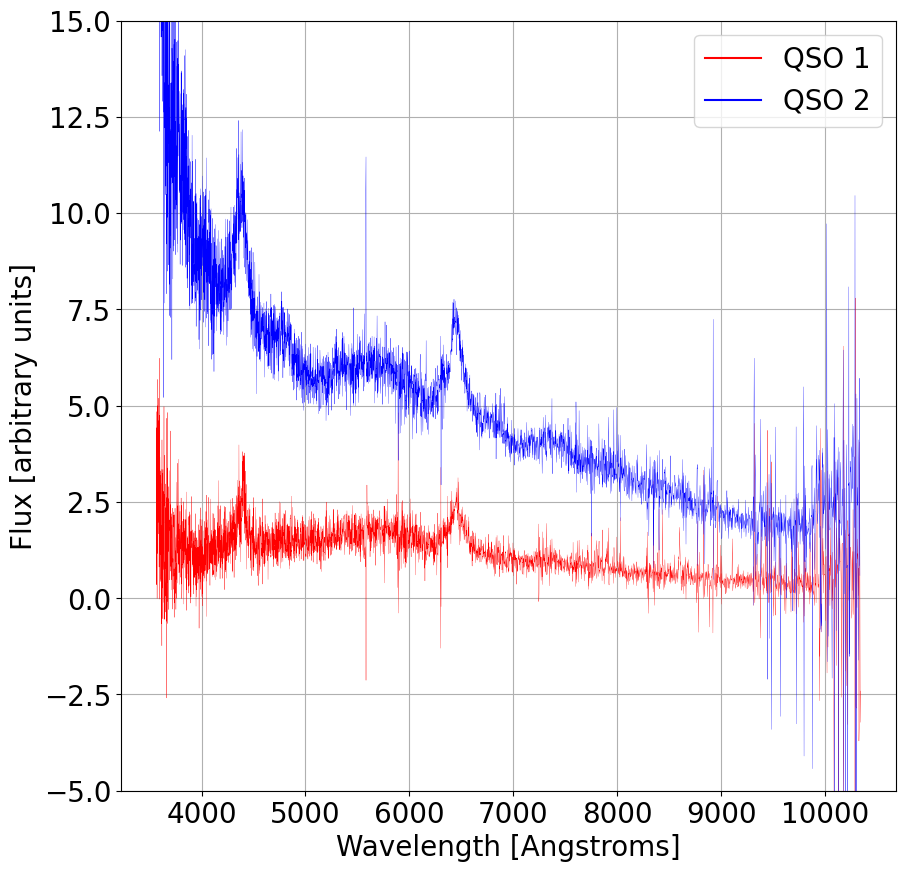

In [195]:
plt.figure(figsize = (10, 10))
plt.plot(10**spec1.loglam, spec1.flux,"-r", lw = 0.2)
plt.plot(10**spec2.loglam, spec2.flux,"-b", lw = 0.2)
plt.plot(4000, 0, "-r", label = "QSO 1")
plt.plot(4000, 0, "-b", label = "QSO 2")
plt.ylim(-5, 15)
#plt.xlim(4000, 5000)
#plt.axvline(6451.180719999999, color = "red") # Spec z for 0086
#plt.axvline(6441.16388, color = "green") # Spec z for 041
#plt.axvline(4401.46676, color = "red") # Spec z for 0086
#plt.axvline(4394.63254, color = "green") # Spec z for 041
plt.grid()
plt.xlabel("Wavelength [Angstroms]",fontsize = 20)
plt.ylabel("Flux [arbitrary units]",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = "upper right", fontsize = 20)
#plt.plot(xnew, power_smooth, "-k")
plt.savefig("qso_spec.pdf")
plt.show()

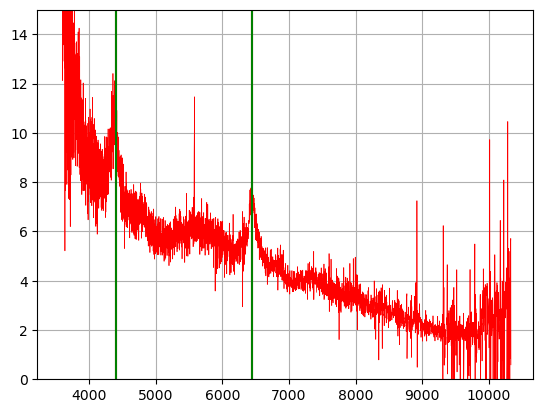

In [140]:
plt.plot(10**spec2.loglam, spec2.flux,"-r", lw = 0.5)
plt.ylim(0, 15)
#plt.xlim(4000, 5000)
plt.axvline(6451.180719999999, color = "red") # Spec z for 0086
plt.axvline(6441.16388, color = "green") # Spec z for 041
plt.axvline(4401.46676, color = "red") # Spec z for 0086
plt.axvline(4394.63254, color = "green") # Spec z for 041
plt.grid()
#plt.plot(xnew, power_smooth, "-k")

In [28]:
10**spec1.loglam[501]

4000.367547682985

In [38]:
10**spec1.loglam[1292]

4799.544552854096

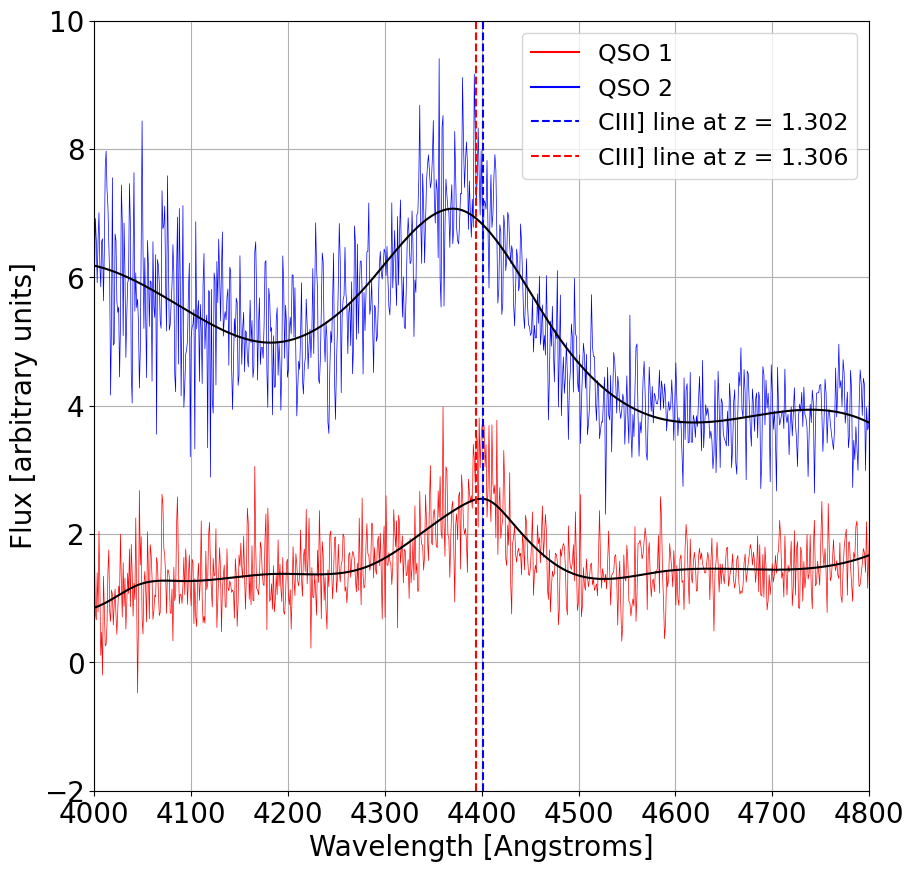

In [198]:
from scipy.interpolate import make_interp_spline, splrep, BSpline
plt.figure(figsize = (10, 10))
plt.plot(4000, 0, "-r", label = "QSO 1")
plt.plot(4000, 0, "-b", label = "QSO 2")
tck_s = splrep(10**spec1.loglam[501:1292], spec1.flux[501:1292], s=len(10**spec1.loglam[501:1292])/4.5)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(4000.367547682985, 4799.544552854096, 300) 

spl = make_interp_spline(10**spec1.loglam[501:1292], spec1.flux[501:1292], k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(10**spec1.loglam, spec1.flux,"-r", lw = 0.5)
plt.xlim(4000,4800)
plt.plot(xnew, BSpline(*tck_s)(xnew), '-k')
plt.grid()

tck_s = splrep(10**spec2.loglam[501:1292], spec2.flux[501:1292], s=len(10**spec2.loglam[501:1292])/2)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(4000.367547682985, 4799.544552854096, 300) 

spl = make_interp_spline(10**spec2.loglam[501:1292], spec2.flux[501:1292], k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(10**spec2.loglam, spec2.flux - 3,"-b", lw = 0.5)
plt.ylim(-2, 10)
plt.xlim(4000,4800)
#plt.axvline(6451.180719999999, color = "blue", ls = "--", label = "Mg II line at z = 1.302") # Spec z for 0086
#plt.axvline(6441.16388, color = "red", ls = "--", label = "Mg II line at z = 1.306") # Spec z for 041
plt.axvline(4401.46676, color = "blue", ls = "--", label = "CIII] line at z = 1.302") # Spec z for 0086
plt.axvline(4394.63254, color = "red", ls = "--", label = "CIII] line at z = 1.306") # Spec z for 041
plt.plot(xnew, BSpline(*tck_s)(xnew) - 3, '-k')
plt.grid()
plt.xlabel("Wavelength [Angstroms]",fontsize = 20)
plt.ylabel("Flux [arbitrary units]",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = "upper right", fontsize = 17)
plt.savefig("ciii.pdf")
plt.grid()

In [159]:
tck_s = splrep(10**spec2.loglam[501:1292], spec2.flux[501:1292], s=len(10**spec2.loglam[501:1292])/2)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(4000.367547682985, 4799.544552854096, 300) 

spl = make_interp_spline(10**spec2.loglam[501:1292], spec2.flux[501:1292], k=3)  # type: BSpline
power_smooth = spl(xnew)

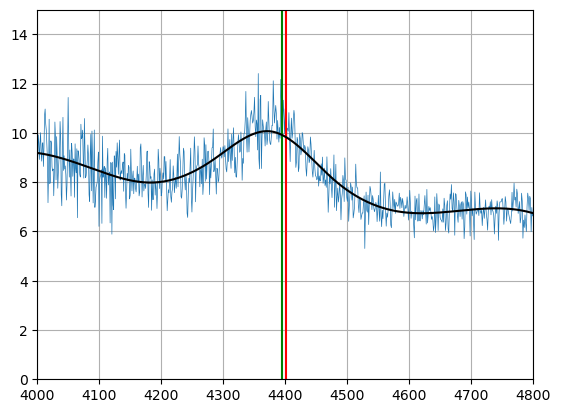

In [160]:
plt.plot(10**spec2.loglam, spec2.flux,"-", lw = 0.5)
plt.ylim(0, 15)
plt.xlim(4000,4800)
plt.axvline(6451.180719999999, color = "red") # Spec z for 0086
plt.axvline(6441.16388, color = "green") # Spec z for 041
plt.axvline(4401.46676, color = "red") # Spec z for 0086
plt.axvline(4394.63254, color = "green") # Spec z for 041
plt.plot(xnew, BSpline(*tck_s)(xnew), '-k')
plt.grid()

In [102]:
from scipy.interpolate import make_interp_spline, splrep, BSpline

tck_s = splrep(10**spec1.loglam[2262:2931], spec1.flux[2262:2931], s=len(10**spec1.loglam[2262:2931])/11)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(6000.672310547069, 7000.030398481973, 300) 

spl = make_interp_spline(10**spec1.loglam[2262:2931], spec1.flux[2262:2931], k=3)  # type: BSpline
power_smooth = spl(xnew)

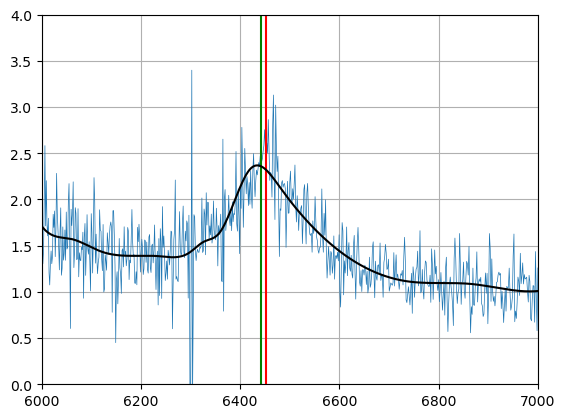

In [103]:
plt.plot(10**spec1.loglam, spec1.flux,"-", lw = 0.5)
plt.ylim(0, 4)
plt.xlim(6000, 7000)
plt.axvline(6451.180719999999, color = "red") # Spec z for 0086
plt.axvline(6441.16388, color = "green") # Spec z for 041
#plt.plot(xnew, power_smooth, "-k")
plt.plot(xnew, BSpline(*tck_s)(xnew), '-k')
plt.grid()
plt.show()

In [104]:
tck_s = splrep(10**spec2.loglam[2266:2935], spec2.flux[2266:2935], s=len(10**spec2.loglam[2266:2935])/7)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(6000.672310547069, 7000.030398481973, 300) 

spl = make_interp_spline(10**spec1.loglam[2266:2935], spec1.flux[2266:2935], k=3)  # type: BSpline
power_smooth = spl(xnew)

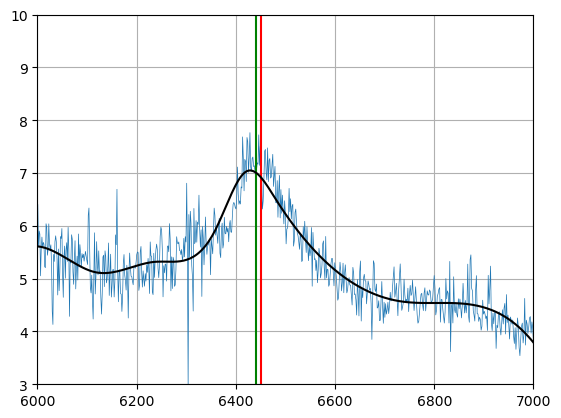

In [105]:
plt.plot(10**spec2.loglam, spec2.flux,"-", lw = 0.5)
plt.ylim(3, 10)
plt.xlim(6000, 7000)
plt.axvline(6451.180719999999, color = "red") # Spec z for 0086
plt.axvline(6441.16388, color = "green") # Spec z for 041
plt.plot(xnew, BSpline(*tck_s)(xnew), '-k')
plt.grid()
plt.show()

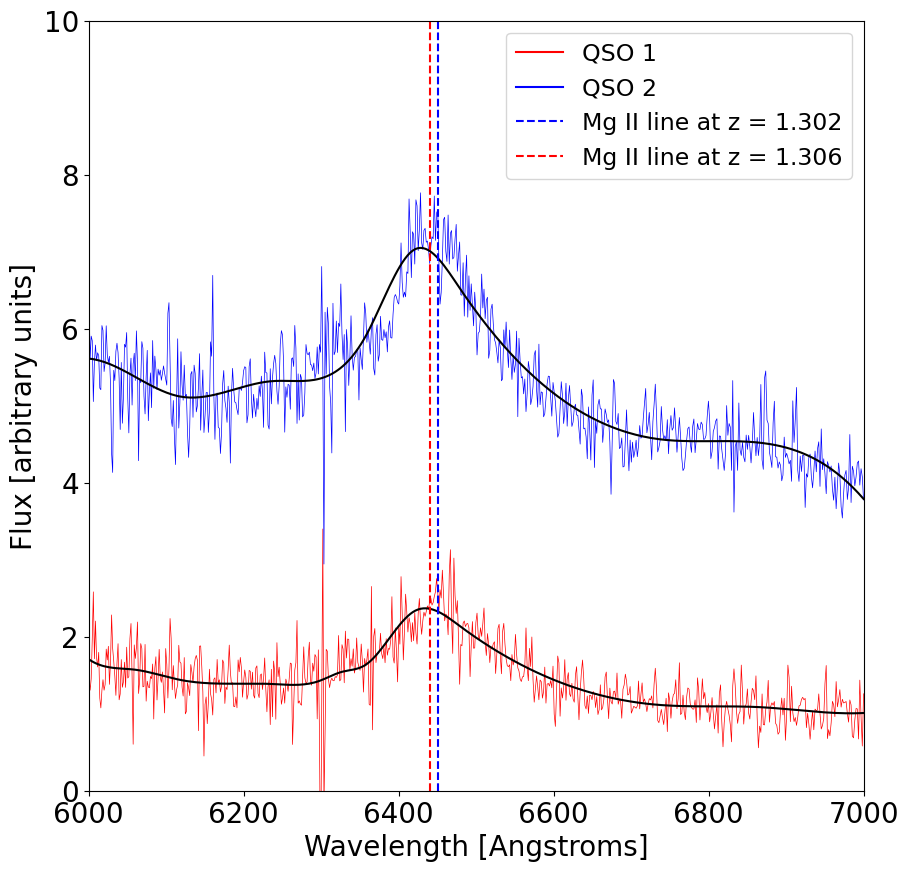

In [199]:
from scipy.interpolate import make_interp_spline, splrep, BSpline
plt.figure(figsize = (10, 10))
plt.plot(6000, 0, "-r", label = "QSO 1")
plt.plot(6000, 0, "-b", label = "QSO 2")
tck_s = splrep(10**spec1.loglam[2262:2931], spec1.flux[2262:2931], s=len(10**spec1.loglam[2262:2931])/11)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(6000.672310547069, 7000.030398481973, 300) 

spl = make_interp_spline(10**spec1.loglam[2262:2931], spec1.flux[2262:2931], k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(10**spec1.loglam, spec1.flux,"-r", lw = 0.5)
#plt.plot(xnew, power_smooth, "-k")
plt.plot(xnew, BSpline(*tck_s)(xnew), '-k')

tck_s = splrep(10**spec2.loglam[2266:2935], spec2.flux[2266:2935], s=len(10**spec2.loglam[2266:2935])/7)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(6000.672310547069, 7000.030398481973, 300) 

spl = make_interp_spline(10**spec1.loglam[2266:2935], spec1.flux[2266:2935], k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(10**spec2.loglam, spec2.flux,"-b", lw = 0.5)
plt.ylim(0, 10)
plt.xlim(6000, 7000)
plt.plot(xnew, BSpline(*tck_s)(xnew), '-k')
plt.axvline(6451.180719999999, color = "blue", ls = "--", label = "Mg II line at z = 1.302") # Spec z for 0086
plt.axvline(6441.16388, color = "red", ls = "--", label = "Mg II line at z = 1.306") # Spec z for 041
#plt.axvline(4401.46676, color = "blue", ls = "--", label = "CIII line at z = 1.302") # Spec z for 0086
#plt.axvline(4394.63254, color = "red", ls = "--", label = "CIII line at z = 1.306") # Spec z for 041
plt.grid()
plt.xlabel("Wavelength [Angstroms]",fontsize = 20)
plt.ylabel("Flux [arbitrary units]",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = "upper right", fontsize = 17)
plt.savefig("mgii.pdf")
plt.grid()

In [508]:
4400/(1+1.305)

1908.893709327549

In [399]:
6430/(1+1.3)

2795.6521739130435

In [411]:
2798*(1+1.30564)

6451.180719999999

In [414]:
2798*(1+1.30206)

6441.16388

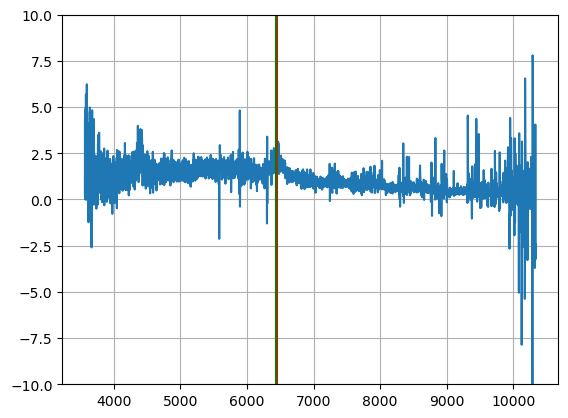

In [420]:
plt.plot(10**spec1.loglam, spec1.flux,"-")
plt.ylim(-10, 10)
#plt.xlim(6000, 7000)
plt.axvline(6451.180719999999, color = "red") # Spec z for 0086
plt.axvline(6441.16388, color = "green") # Spec z for 041
plt.grid()
plt.show()

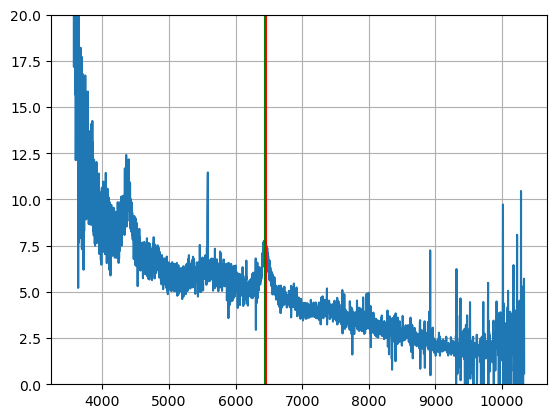

In [418]:
plt.plot(10**spec2.loglam, spec2.flux,"-")
plt.ylim(0, 20)
#plt.xlim(6000, 7000)
plt.axvline(6451.180719999999, color = "red") # Spec z for 0086
plt.axvline(6441.16388, color = "green") # Spec z for 041
plt.grid()
plt.show()